# Landfill Inference
This notebook is created for testing out the landfill detection AI model.

## Setup
Making sure that everything is in place.

In [1]:
import os
import dotenv
import boto3
dotenv.load_dotenv()

! export AWS_REGION=eu-west-1
! aws s3 ls --region=eu-west-1

client = boto3.client("sagemaker-runtime", region_name="eu-west-1")


2025-01-07 17:16:10 aereal-waste
2024-11-12 06:21:08 amazon-connect-e9096db21c9b
2024-10-30 20:08:59 amazon-datazone-772012299168-eu-west-1-802356441
2024-10-30 20:16:45 amplify-visualizzazionecredi-dev-103043-deployment
2024-10-30 20:16:45 amplify-visualizzazionecredi-stg-90157-deployment
2024-10-26 06:56:17 ariston-temp
2024-10-30 21:07:15 aws-glue-assets-772012299168-eu-west-1
2024-11-23 12:11:35 aws-sam-cli-managed-default-samclisourcebucket-1764235s5voef
2024-11-07 23:03:04 aws-sam-cli-managed-default-samclisourcebucket-1lof9ldfv3e5r
2023-10-05 12:42:46 badrock-test-connect-genai
2024-12-27 10:42:22 cdk-hnb659fds-assets-772012299168-eu-west-1
2023-07-20 18:23:11 cdk-hnb659fds-assets-772012299168-us-east-1
2024-10-30 22:47:31 cdkpipelinestack-cdkpipelineartifactsbucketdd732d7-8isqjf8cbucr
2024-10-30 22:47:32 cdkpipelinestack-pipelineartifactsbucket22248f97-obfzqrufg5xb
2024-10-30 22:47:32 cdkpipelinestack-pipelineartifactsbucketaea9a052-a5mmqkp4dzic
2024-10-30 22:47:32 cdkpipelines

## Config
Configuring Global variables

In [2]:
DATA_PATH=".in"
ENDPOINT_NAME = "scrnts-dev-landfill-yolo-endpoint"

## Prepare Payload

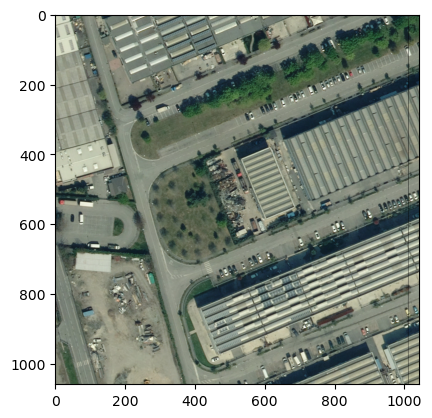

In [18]:
import base64
import cv2
from matplotlib import pyplot as plt


img_name = "inference-4.png"
image_base64 = None

# Open image as base64
image_path = os.path.join(DATA_PATH, img_name)
with open(image_path, "rb") as image_file:
    image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

image_cv2 = cv2.imread(image_path)
image_cv2_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
plt.imshow(image_cv2_rgb)
plt.show()

## Invoke Sagemaker endpoint and print bounding box

In [19]:
import json

response = client.invoke_endpoint(
    EndpointName=ENDPOINT_NAME,
    ContentType="image/jpeg",
    Body=json.dumps(image_base64),
)

result = json.loads(response["Body"].read().decode("utf-8"))

In [20]:
print("Inference result:")
print(json.dumps(result, indent=4))

Inference result:
{
    "inference": [
        {
            "confidence": 0.23755,
            "bbox": {
                "x1": 0.0,
                "y1": 0.0,
                "x2": 94.97244,
                "y2": 120.56053
            }
        },
        {
            "confidence": 0.19432,
            "bbox": {
                "x1": 451.86618,
                "y1": 451.95657,
                "x2": 557.0896,
                "y2": 625.43774
            }
        },
        {
            "confidence": 0.15556,
            "bbox": {
                "x1": 142.01732,
                "y1": 739.92114,
                "x2": 261.85934,
                "y2": 861.39917
            }
        }
    ]
}


0.0| 0.0| 94.97244| 120.56053| 0.23755| waste
451.86618| 451.95657| 557.0896| 625.43774| 0.19432| waste
142.01732| 739.92114| 261.85934| 861.39917| 0.15556| waste


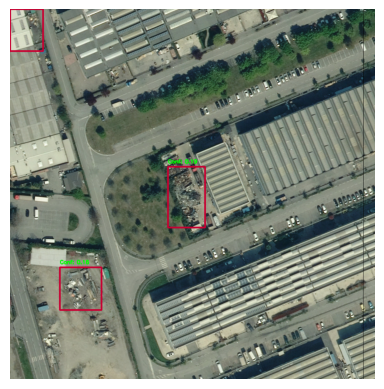

In [21]:
import copy

# Define a temp image to be modified
temp_image = copy.deepcopy(image_cv2_rgb)

inferences = result['inference']
for inf in inferences:
    x1 = inf["bbox"]["x1"]
    y1 = inf["bbox"]["y1"]
    x2 = inf["bbox"]["x2"]
    y2 = inf["bbox"]["y2"]
    cls = "waste"
    conf = inf["confidence"]
    print("| ".join([str(x1), str(y1), str(x2), str(y2), str(conf), str(cls)]))
    cv2.rectangle(temp_image, (int(x1), int(y1)), (int(x2), int(y2)), (200, 0, 50), 3)
    label = f"Conf: {conf:.2f}"
    cv2.putText(
        temp_image,
        label,
        (int(x1), int(y1) - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        2,
    )
plt.imshow(temp_image)
plt.axis("off")
plt.show()